In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pyplot
import numpy as np,matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

In [33]:
data = pd.read_csv("PS_20174392719_1491204439457_log.csv")

In [34]:
data = data.drop(["nameDest", "nameOrig"] , axis = 1).sample(10000)
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4647157,330,PAYMENT,21874.19,271341.08,249466.90,0.00,0.00,0,0
2719938,211,CASH_OUT,48749.97,0.00,0.00,1285692.31,1334442.28,0,0
6139219,544,CASH_IN,185398.44,7016736.40,7202134.83,2589708.20,2404309.77,0,0
99811,10,CASH_OUT,127940.27,0.00,0.00,9117.00,137057.28,0,0
3237805,250,CASH_OUT,147493.10,50364.00,0.00,0.00,147493.10,0,0


In [35]:
data = pd.concat([data, pd.get_dummies(data['type'],drop_first=True)] , axis = 1).drop(["type"], axis = 1)
data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
4647157,330,21874.19,271341.08,249466.90,0.00,0.00,0,0,0,0,1,0
2719938,211,48749.97,0.00,0.00,1285692.31,1334442.28,0,0,1,0,0,0
6139219,544,185398.44,7016736.40,7202134.83,2589708.20,2404309.77,0,0,0,0,0,0
99811,10,127940.27,0.00,0.00,9117.00,137057.28,0,0,1,0,0,0
3237805,250,147493.10,50364.00,0.00,0.00,147493.10,0,0,1,0,0,0


In [36]:
scaler = StandardScaler()
scaler.fit(data.drop('isFraud',axis=1))
scaled_data = scaler.transform(data.drop('isFraud',axis=1))

In [37]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(scaled_data,data['isFraud'],test_size=0.2,train_size=0.8)
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
validation_scores = {}
for degree in range(1,7,1):
  PolyDegree = PolynomialFeatures(degree= degree, include_bias = False, interaction_only = True)
  data_new= PolyDegree.fit_transform(x_train)
  model= LogisticRegression(penalty = "none", max_iter=10000)
  validation_score = cross_val_score(model,data_new,y_train, cv=skf, scoring = 'f1').mean()
  validation_scores[degree] = validation_score

In [38]:
print(validation_scores)

{1: 0.55, 2: 0.125, 3: 0.125, 4: 0.0, 5: 0.0, 6: 0.0}


In [39]:
PolyDegree = PolynomialFeatures(degree= 1, include_bias = False, interaction_only = True)
data_new= PolyDegree.fit_transform(x_train)
x_test_transformed = PolyDegree.fit_transform(x_test)
model= LogisticRegression(penalty = "none", max_iter=10000)
model.fit(data_new, y_train)

print(f"Model Accuracy = {model.score(x_test_transformed, y_test)*100}%")

Model Accuracy = 99.85000000000001%


In [50]:
validation_score_reg = []
for lambdda in np.arange(0.0, 20, step=0.1):
    if lambdda==0:
          Reg= LogisticRegression(penalty = "l2", max_iter=5000, C = 1000)
          validation_score = cross_val_score(model,data_new,y_train, cv=skf, scoring = 'f1').mean()
          validation_score_reg.append(validation_score)
    else:
          Reg= LogisticRegression(penalty = "l2", max_iter=5000, C = 1/lambdda)
          validation_score = cross_val_score(model,data_new,y_train, cv=skf, scoring = 'f1').mean()
          validation_score_reg.append(validation_score)
#   Reg= LogisticRegression(penalty = "l2", max_iter=5000, C = 1/lambdda)
#   validation_score = cross_val_score(model,data_new,y_train, cv=skf, scoring = 'f1').mean()
#   validation_score_reg.append(validation_score)

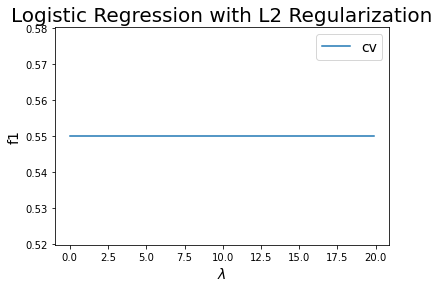

In [51]:
plt.plot(np.arange(0.0, 20, step=0.1), validation_score_reg, label="cv")
plt.xlabel("$\\lambda$", fontsize=14)
plt.ylabel("f1", fontsize=14)
plt.title("Logistic Regression with L2 Regularization", fontsize=20)
plt.legend(fontsize=14)
plt.show()